In [ ]:
# These commands set up zef for a Google Colab environment
!pip install --upgrade zef
import os; os.environ["ZEFDB_OFFLINE_MODE"] = "TRUE"

# Introduction

There are many features of the zef ecosystem to explore but several are core
concepts from which the rest can be understood. This tutorial aims to quickly
demonstrate the core parts of the zef language. At the end, you should
understand:

- How to query a graph, by traversing relations and accessing atomic values.
- Append new information to a graph using the transact and shorthand syntaxes.
- Understand how to use the lazy zef operator syntax.
- Be able to share your graph with others and collaborate.

In particular, these programmatic operations and types will be covered:

- `Graph`
- `ZefRef`
- `GraphDelta`
- `ET`, `RT`
- `Out`, `In`, `out_rel`, `in_rel`, `Outs`, `Ins`
- `collect`, `run`, `for_each`
- `Z["..."]`
- `now`, `value`, `single`, `terminate`, `map`, `uid`, `all`, `frame`

# Goal

Let's create a database representation of something similar to the relation database shown at [https://www.sqltutorial.org/sql-sample-database/](https://www.sqltutorial.org/sql-sample-database/).

![](https://www.sqltutorial.org/wp-content/uploads/2016/04/SQL-Sample-Database-Schema.png)

This information is meant to describe a company's distribution of employees,
jobs and departments. As we are using a graph database, we will not duplicate
this exact structure as it is inflexible. Instead, we will show some of the unique
flexibility of graph databases and zefDB's flat layout. In this tutorial, the
equivalent graph layout to the above relational table layout will be:

![](graph_layout.svg)

where `*` indicates multiple relations may be present.

## Filling in some structure

Firstly, create a blank graph and add to it some entities representing people and departments.

In [78]:
from zef import *
from zef.ops import *

g = Graph()

Creating a graph is done with `Graph()`. By default, this creates a local graph
which is not synchronized with ZefHub.

In [79]:
z_alice = ET.Employee | g | run
z_bob = ET.Employee | g | run
z_charlie = ET.Employee | g | run
z_alex = ET.Employee | g | run

z_hr = ET.Department | g | run
z_research = ET.Department | g | run

(z_alice, RT.WorksFor, z_research) | g | run
(z_bob, RT.WorksFor, z_hr) | g | run
(z_charlie, RT.WorksFor, z_hr) | g | run
(z_charlie, RT.WorksFor, z_research) | g | run;

The notation `<template> | g` creates an `Effect` to append a single fact to the
graph. We `run` this effect, and the return value is a `ZefRef` which is a
reference to that created entity or relation. In this list we have two "types"
which are an entity type `ET` and a relation type `RT`. You can think of these
as nearly equivalent to a string naming the type.

In [80]:
z_alice

<ZefRef #97 ET.Employee slice=2>

In [81]:
z_hr

<ZefRef #171 ET.Department slice=6>

:::info

An `ET.Something` or `RT.Something` will add a new type or reuse an existing
type. Under the hood, these are tokenized to integers for optimized accesses and
are consistent across different graphs.

Don't be afraid to create new types. As you add new types, they will be added to
your user namespace, and can be later "forgotten" if you would like to clean up
your namespace.

:::

A key difference here to a relational database is that the employee can have
multiple relations to different departments, a feature which typically requires
multiple table rows in a relational database. In the above, Charlie can work for
both the HR and Research departments. In contrast, Alex works for no department
(maybe they are a new hire or an intern).

The input of the data above is a little clumsy and verbose. We could compress many of the elements into fewer templates:

In [82]:
g = Graph()

[z_alice,z_bob,z_charlie,z_alex,
 z_hr,z_research] = [ET.Employee, ET.Employee, ET.Employee, ET.Employee,
                     ET.Department, ET.Department] | g | run

(z_alice, RT.WorksFor, z_research) | g | run
(z_bob, RT.WorksFor, z_hr) | g | run
(z_charlie, RT.WorksFor, [z_hr, z_research]) | g | run;

In the first line, a template consisting of 4 `ET.Employee`s and 2
`ET.Department`s requests that 6 new entities be created. The return value is
then "unpacked" into 6 different variables. The final line of code creates two
relations from `z_charlie` to `z_hr` and `z_research`.

Even with the compressed syntax there are a couple of problems:
- it looks confusing
- multiple database transactions are caused by each `... | g | run`.

Instead, we can use the `transact` operator:

In [83]:
g = Graph()

receipt = [
    ET.Employee["alice"],
    ET.Employee["bob"],
    ET.Employee["charlie"],
    ET.Employee["alex"],

    (Z["alice"], RT.WorksFor, Z["research"]),
    (Z["bob"], RT.WorksFor, Z["hr"]),
    (Z["charlie"], RT.WorksFor, Z["hr"]),
    (Z["charlie"], RT.WorksFor, Z["research"]),

    ET.Department["hr"],
    ET.Department["research"],
] | transact[g] | run

z_alice = receipt["alice"]
z_bob = receipt["bob"]
z_charlie = receipt["charlie"]
z_alex = receipt["alex"]

z_hr = receipt["hr"]
z_research = receipt["research"]

Here, each item in the list passed to the `GraphDelta` is one fact to be added
to the database, but all will be done in the one transaction. There are two
kinds of facts shown here:

1. a new entity (e.g. `ET.Employee`) and
2. a new relation `(a, RT.Something, c)`.

To connect the facts together, each entity/relation can be given an internal (and temporary) name. A string following an `ET` or `RT` sets this internal name (e.g. `ET.Employee["alice"]`) and the special object `Z` can be used to reference this name (e.g. `Z["alice"]`).

After the GraphDelta has been `run` on the graph, a "receipt" is returned which allows access to the created
entities and relations via their internal names.

The order is also not important - for example, the fact describing the relation
between `Z["alice"]` and `Z["research"]` is given before the name "research"
is known (in `ET.Department["research"]`). You can use this to organise the
`transact` as makes sense in your particular context.

:::tip

One can think of the `Z["name"]` notation as similar to using a variable called
`name`. Because a `transact` uses a declaritive style (that is, it
declares the facts to create) rather than an imperative style (which would list
a series of actions to perform in a specific order) variables are not necessary.

For example, the `transact`

```py
reciept = [
    ET.Employee["alice"],
    (Z["alice"], RT.WorksFor, Z["research"]),
    ET.Department["research"]
] | transact[g] | run

z_alice = receipt["alice"]
z_research = receipt["research"]
```

could be re-imagined in an imperative style with the pseudo-code (notice the
analogy between `Z["alice"]` and `alice`:

```py
alice = create_entiy(ET.Employee)
research = create_entity(ET.Research)
link_entities_by_relation(alice, RT.Department, research)
```

Note this pseudo-code does not work and the functions `create_entity` and
`link_entities_by_relation` do not exist!

:::

## Attaching some details

The above was only the high-level structure between some employees and some
departments. We didn't need to specify exactly what an `ET.Employee`
entity is, or what properties it might have. In fact, in zefDB there is no such
concept of a "property" of an entity. Instead, we use a flat representation to
attach other details. For example:

In [84]:
[
    (z_alice, RT.FirstName, "Alice"),
    (z_alice, RT.LastName, "Smith"),
    (z_alice, RT.Email, "alice.smith@invalid.address"),
    (z_alice, RT.Email, "alice.smith52@backup.address"),
    (z_alice, RT.HireDate, Time("2022-01-11")),
    (z_alice, RT.Salary, QuantityFloat(73100.0, EN.Unit.AUD)),

    (z_bob, RT.FirstName, "Bob"),
    # ...
    (z_charlie, RT.FirstName, "Charlie"),
    # ...
    (z_alex, RT.FirstName, "Alex"),
    # ...

    (z_hr, RT.Name, "HR"),
    # ...
    (z_research, RT.Name, "Research"),
    # ...
] | transact[g] | run;

We have shown a variety of types available for values. It is possible assign
`String`, `Int`, `Float`, `Time`, `QuantityFloat`, `QuantityInt` to what are
known as "atomic entities". In contrast, entities only have an identity but
never a value. To show the current state of `z_alice` use the `yo` op:

```py
yo(now(z_alice))                # option 1

z_alice | now | yo | collect    # option 2
```

You should see something like

```text
================================================== Historical  View ==================================================
===================================== Seen from: 3: 2022-01-12 12:36:28 (+0800)  =================================
<...snip...>
    1x:     (z:ET.Employee) -------------------------(RT.WorksFor)-----------------------> (ET.Department)
                (z) ----(603d3be2b5ba277a48cc05798023a1df)---> (264a2177d0a36cce48cc05798023a1df)

    1x:     (z:ET.Employee) ------------------------(RT.FirstName)-----------------------> (AET.String)
                (z) ----(8e6809d8f232af7b48cc05798023a1df)---> (72f79ec427603a7448cc05798023a1df [latest val: Alice])
<...snip...>
    1x:     (z:ET.Employee) -------------------------(RT.HireDate)-----------------------> (AET.Time)
                (z) ----(93b8c0bdc806fd6548cc05798023a1df)---> (21157012f1e9d0ad48cc05798023a1df [latest val: 2022-01-11 00:00:00 (+0800)])

    1x:     (z:ET.Employee) --------------------------(RT.Salary)------------------------> (AET.QuantityFloat.AUD)
                (z) ----(061547c736a45a2648cc05798023a1df)---> (6bd9b5b7b42ea9bb48cc05798023a1df [latest val: <QuantityFloat: 73100 EN.Unit.AUD>])
<...snip...>
```

Alice is an employee with many relations heading outwards from the entity. These
are all "at the same level", i.e. flat. The relation connecting Alice to the
research department entity (of type `ET.Department`) is at the same level as the
relation connecting Alice to the atomic entity containing her first name "Alice"
(of type `AET.String`).

:::caution

If you simply ask for `yo(z_alice)` (try this) you will not see all of the above
information. That's because each `ZefRef` is simply a pair of `(identity, reference_frame)` and `z_alice` was returned from a reference frame when the
entity was first created, before any of Alice's properties were attached. This should be noticable in the
header of the `yo` output above, where the second line shows "Seen from 3". This
emphasizes that the "time slice" (here 3) the information about the entity is
shown from may be in the past.

:::

:::info 

Compared with the SQL table definition, Alice is missing several columns:

- `employee_id`: this is not needed as every entity on the graph has a unique ID already (try `uid(z_alice)`)
- `phone_number`: we chose to not provide a phone number, which is valid on a graph. A relation database might choose to use a sentinel value to indicate a missing phone number instead.
- `department_id`: instead of indirectly connecting the employee to a department, we have directly linked the employee using a relation.
- `email`: we have provided two email addresses for Alice. This is easy to do in a graph database but requires much forethought in a relational database.

:::

:::info

Each line in the `GraphDelta` that added one property (e.g. `(z_alice, RT.FirstName, "Alice")`) is a shorthand for several elementary operations. The same effect could be obtained via:

```
ae = AET.String | g | run              # Create the atomic entity without a value
ae | assign_value["Alice"] | run       # Assign a value to the atomic entity
(z_alice, RT.FirstName, ae) | g | run  # Connect the atomic entity to z_alice
# ... the above is the same as ...
(z_alice, RT.FirstName, "Alice") | g | run
```

:::

## Injecting some elegance

While the underlying layout on the graph might be flat, we often think about data in a tree-like manner. So there is another option to provide the information for an entity:

In [85]:
{z_bob: {
    #RT.FirstName: "Bob", # This is commented out to prevent adding a RT.FirstName twice.
    RT.LastName: "Jones",
    RT.Email: "bob.jones@invalid.address",
    RT.HireDate: Time("2022-01-12"),
    RT.Salary: QuantityFloat(100.0, EN.Unit.AUD)
}} | g | run;

## Querying the data

If we did not know Alice's name and wanted to obtain this from the `ZefRef` of `z_alice`, then we could write the following:

In [86]:
first_name_ae = z_alice | now | Out[RT.FirstName] | collect
name_string = first_name_ae | value | collect

# ... or ...

name_string = z_alice | now | Out[RT.FirstName] | value | collect

name_string

'Alice'

Here, the operation `Out` says to "traverse the prior `ZefRef` along the
following outgoing relation", that is `RT.FirstName`. The output of this is
itself another `ZefRef`. There is an equivalent operation `In` for traversing
along an incoming relation, hence:

In [87]:
z_alice | now | Out[RT.FirstName] | In[RT.FirstName] | collect == now(z_alice)

True

Finally, once we have the `ZefRef` to the atomic value containing
the name, we grab the value itself using the op `value`.

You might be wondering what the `| collect` operations are for, and why there
seem to be `|` characters everywhere. This is due to the lazy evaluation
features of zefDB. If we write

In [88]:
z_alice | now

LazyValue(<ZefRef #187 ET.Employee slice=2> | now)

or

In [89]:
z_alice >> RT.FirstName

LazyValue(<ZefRef #187 ET.Employee slice=2> | out_out_old[RT.FirstName])

we obtain an object of type `LazyValue` instead of a `ZefRef` that we might
expect. This allows for the composition of expressions without evaluation,
useful for functional design and an essential aspect of distributed queries and
computing. To cause evaluation, we can pass this `LazyValue` through a
`collect`.

:::tip

For named operations, like `now` and `value`, we can cause immediate evaluation
using the function call syntax:

```py
value(now(z_alice) | Out[RT.FirstName]) == z_alice | now | Out[RT.FirstName] | value | collect
```

:::

To obtain a quick visualisation of the current graph layout, we can use the
`graphviz` operator. This requires both the [program
graphviz](https://graphviz.org/download/) and the [python package
`graphviz`](https://pypi.org/project/graphviz/) to be installed. Then you can
simply run:

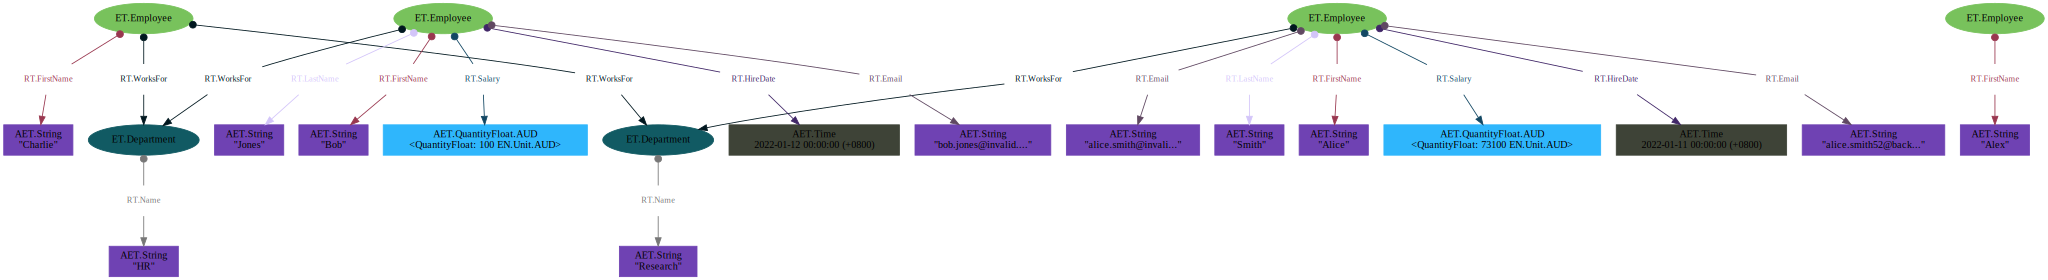

In [90]:
# Make sure both the graphviz program and the python package graphviz are
# installed before running this command.
g | now | all | graphviz | collect

This will autogenerate a visualisation with a layout that will likely require
some zooming to view all of the individual parts.

Note: the `graphviz` return type is an Image which is automatically displayed in Jupyter. At the REPL you should instead, for example, run save this to a variable `viz` and run `viz.view()`.

## Exploiting relations

Relations in all graph databases can connect entities, that is, a relation can begin or
end at an entity. In Zef graphs, relations are also allowed to begin or end at a
relation. This is very helpful to represent facts which are connected to a pair
of entities. For example, if an employee is associated with multiple
departments, like "Charlie" in our example above, we might want to attach
additional facts that describe what role or what fraction of time Charlie
spends in the HR and Research departments. This might be better explained by
example, creating a new employee:

In [91]:
# We create a new employee to show how everything can be added in one step
receipt = [
    {ET.Employee["zaphod"]: {
        RT.FirstName: "Zaphod",
        RT.LastName: "Beeblebrox",
    }},

    (Z["zaphod"], RT.WorksFor["zaphod-hr"], z_hr),
    (Z["zaphod"], RT.WorksFor["zaphod-research"], z_research),

    {Z["zaphod-hr"]: {
        RT.Role: "busy body",
        RT.Fraction: 0.1,
    }},

    {Z["zaphod-research"]: {
        RT.Role: "general nuisance",
        RT.Fraction: 0.9,
    }},
] | transact[g] | run

z_zaphod = receipt["zaphod"]

Notice that we can assign internal names to the `RT.WorksFor` relations and this
is one method to create relations out of relations. Alternatively, we can first
obtain a relation using the `relation` operator.

In [92]:
z_charlie_hr = relation(now(z_charlie), now(z_hr))
z_charlie_research = relation(now(z_charlie), now(z_research))

[
    (z_charlie_hr, RT.Role, "Recruitment"),
    (z_charlie_research, RT.Role, "Manager"),
] | transact[g] | run;

For Zaphod, we included a `RT.Fraction` but this was left off of Charlie's details. The lack of a `RT.Fraction` needs to be understood in the graph context.
It could be interpreted as:

- Charlie spends equal time in all roles, or
- Charlie provides floating support, or
- the data is incomplete and represents an error in the data

Exactly which of these interpretations apply would
be part of the data model.

If we wish to remove a fact from the database, we can terminate it:

In [93]:
z_zaphod | terminate | g | run

# Alternatively...
# [terminate(z_zaphod)] | transact[g] | run

<ZefRef #931 ET.Employee slice=7>

Terminating an entity such as `z_zaphod` will also terminate any relations that
were pointing to it. Hence, the `RT.WorksFor` relation connecting `z_zaphod` to
`z_hr` was also terminated, along with the `RT.Role` in turn.

:::tip

Knowing when to place facts on a relation between two entities, as opposed to
one of the entities directly can often be determined by what behavior would be
expected by `terminate`. For example, the `RT.Role` fact would become
meaningless if either of `z_zaphod` or `z_hr` were removed, hence placing it on
the connecting relation makes sense.

In contrast, a hire date associated with Zaphod makes more sense to be attached
directly to `z_zaphod`, even though it might also be the same time as when
Zaphod started in the HR department. If the department entity were terminated,
then it would be incorrect to also remove the hire date of Zaphod.

:::

## Queries out of nothing

So far, we have created items on the graph, and then accessed them using the
`ZefRef` that was returned from the creation effect. If we instead approach the
graph without any prior references, we need to be able to access these
previously stored facts.

A Zef query is not formulated like an SQL query. We can directly interact with a
graph, and programmatically apply filtering, traversals and transformations.
Here is how we could obtain all employee entities, and print their IDs and first
names:

In [94]:
employees = g | now | all[ET.Employee] | collect

# Using zef ops
make_output = lambda z: (uid(z), value(z | Out[RT.FirstName]))
employees | map[make_output] | for_each[unpack[print]]

# Using traditional python
for z in employees:
    print(*make_output(z))

b501be56d899f77e931b00e1e97a4f5c53bdc9821d767ec8 Alex
820a3434a983e82e931b00e1e97a4f5c53bdc9821d767ec8 Charlie
e792dc1ab793b393931b00e1e97a4f5c53bdc9821d767ec8 Bob
21bd50c7b8ddd159931b00e1e97a4f5c53bdc9821d767ec8 Alice
b501be56d899f77e931b00e1e97a4f5c53bdc9821d767ec8 Alex
820a3434a983e82e931b00e1e97a4f5c53bdc9821d767ec8 Charlie
e792dc1ab793b393931b00e1e97a4f5c53bdc9821d767ec8 Bob
21bd50c7b8ddd159931b00e1e97a4f5c53bdc9821d767ec8 Alice


`employees` is a list holding a bunch of `ZefRef`s.

Notice that there should be no "Zaphod" in the list, as this node was
terminated. However, zefDB is an append-only database with time travel built in,
so it is possible to go back and view the facts of the graph at an earlier time:

In [95]:
# This code assumes z_zaphod is the same variable as would have been created
# from the code earlier in this tutorial.

employees = z_zaphod | frame | all[ET.Employee] | collect
employees | map[make_output] | for_each[unpack[print]];

b501be56d899f77e5888ae8da8d112ef53bdc9821d767ec8 Alex
820a3434a983e82e5888ae8da8d112ef53bdc9821d767ec8 Charlie
e792dc1ab793b3935888ae8da8d112ef53bdc9821d767ec8 Bob
21bd50c7b8ddd1595888ae8da8d112ef53bdc9821d767ec8 Alice
aae05777c02978bc5888ae8da8d112ef53bdc9821d767ec8 Zaphod


Here, we use the op `frame`  to get the reference frame of `z_zaphod`, which is the frame
in which the `ET.Employee` for Zaphod was created. We then ask for all
`ET.Employee` in the context of this reference frame.

It is also possible ask for all employees that ever existed:

In [96]:
# First create a new employee:
z_trillian,_,_ = (ET.Employee, RT.FirstName, "Trillian") | g | run

employees = g | all[ET.Employee] | collect
# Note: as the employees have no reference frame, we need to
# pass in one to `value` to allow it to return something sensible.
employees | map[lambda z: (uid(z), z | Out[RT.FirstName] | value[now(g)] | collect)] | for_each[unpack[print]];

b501be56d899f77e53bdc9821d767ec8 Alex
820a3434a983e82e53bdc9821d767ec8 Charlie
e792dc1ab793b39353bdc9821d767ec8 Bob
21bd50c7b8ddd15953bdc9821d767ec8 Alice
aae05777c02978bc53bdc9821d767ec8 Zaphod
d974cebb8e1d2d6853bdc9821d767ec8 Trillian


Here, we simply ask for all `ET.Employee` of the graph, which _not_ a reference
frame, in contrast to `g | now | all[...]`. We see all employees, including both
"Zaphod" and "Trillian" despite there never being a single time in which both
were employeed (remember the order, the Zaphod entity was created, then
terminated, then the Trillian entity was created).

:::caution

Objects returned from a reference frame are `ZefRef`s which are effectively a
`(identity, reference_frame)` pair. The objects returned by `g | all[...]` are
`EZefRef`s ("eternal ZefRefs"), which are the `identity` alone. More discussion
on the differences between a `ZefRef` and `EZefRef` can be found [here(todo)](/).

:::

To ask for a particular employee we can filter on these results. For example:

In [97]:
z_found = (g | now | all[ET.Employee]
 | filter[Out[RT.FirstName]
   | value
   | equals["Alice"]]
 | single
 | collect)

The `filter` op filters a list based on the predicate function/op curried into
it. Note that `Z >> RT.FirstName` is effectively the same as `lambda z: z >> RT.FirstName`. Finally, the `single` op takes a list of a single element and
returns that element. If the list is empty, or contains two or more elements, it
would raise an error.

As this is programmatic, we can now continue to use the `ZefRef` result in
`z_found` to query the graph:

In [98]:
print(f"The employee {value(z_found | Out[RT.FirstName])} {value(z_found | Out[RT.LastName])} was hired on {value(z_found | Out[RT.HireDate])}")

The employee Alice Smith was hired on 2022-01-11 00:00:00 (+0800)


## Complex queries

In SQL, joins between multiple tables are necessary to perform interesting
queries. In graph databases, we instead traverse relations. We have already seen
how we can traverse a single relation with `z_zaphod | Out[RT.FirstName]`. We can
also traverse multiple relations:

In [99]:
names = z_hr | now | Ins[RT.WorksFor] | map[Out[RT.FirstName] | value] | collect
print(names)

['Charlie', 'Bob']


Here, `z | Ins[RT.WorksFor]` asks for all sources of `RT.WorksFor` relations
incoming to `z`. It will always return a list, even if there is only a single
relation, hence `z | In[RT.WorksFor]` is equivalent to `z | Ins[RT.WorksFor] | single`.

Finally, we have seen how to attach facts to relations, by allowing relations to
start from other relations. To query for this we use `out_rel` and `in_rel` which are
analogous to `Out` and `In`:

In [100]:
roles = z_charlie | now | out_rels[RT.WorksFor] | map[Out[RT.Role] | value] | collect
print(roles)

['Manager', 'Recruitment']


The `out_rels[RT.WorksFor]` returns a list of the relations outgoing from the
entity, instead of their targets, as would be returned by `Outs[RT.WorksFor]`. In fact, we can say that `z | Outs[RT.Something] == z | out_rels[RT.Something] | map[target]`. An alternative way to describe this is "`Out` and `In` follow
relations to one of their end, whereas `out_rel` and `in_rel` stop on the relation".

### Labelling composite queries

Most of the time, we would like to reuse queries. As these are lazy operations,
this as simple as assigning them to a variable:

In [101]:
get_roles_simple = now | out_rels[RT.WorksFor] | map[Out[RT.Role] | value]

get_roles = (Assert[is_a[ET.Employee]]
 | now
 | out_rels[RT.WorksFor]
 | map[Outs[RT.Role] | single_or[None]] # Follow RT.Role if it exists, otherwise return None
 | map[value_or["<missing role name>"]]) # Get the value, but if None return "<missing role name>"

z_charlie | get_roles | collect | run[print]

z_alice | get_roles | collect | run[print]

['Manager', 'Recruitment']
['<missing role name>']


The `get_roles_simple` form is nearly identical to what we wrote before. The
more complex form underneath also includes an assertion (which will complain if
the `ZefRef` passed in is not an `ET.Employee`) and proper handling for the case
that a `RT.Role` is missing. This zefop can now be used more concisely in
interesting cases:

In [102]:
all_roles = (g | now | all[ET.Employee]
 | map[get_roles | collect]
 | concat
 | distinct
 | collect)
print(all_roles)

['Manager', 'Recruitment', '<missing role name>']


Note that we can also write a python function to implement `get_roles` and
decorate it so that it can be used like an op:

In [103]:
@func
def get_roles2(z):
    assert is_a(z, ET.Employee)
    rels = z | now | out_rels[RT.WorksFor]

    roles = []
    g = Graph(z)
    for rel in rels:
        if rel | has_out[RT.Role] | collect:
            role = rel | Out[RT.Role] | value | collect
        else:
            role = "<missing role name>"
        roles.append(role)
    return roles

z_charlie | get_roles2 | collect | run[print]
z_alice | get_roles2 | collect | run[print]

['Manager', 'Recruitment']
['<missing role name>']


A function decorated with `@func` can also be permanently attached to a graph
via the `@func(g)` syntax. See [here(todo)](/) for more detail.

## Persisting data for later use

Although we have left this for last, it is actually one of the simplest steps in
this tutorial. If you would like to save the graph you are working on to be able
to return to it in the future, then simply call:

In [ ]:
g | sync | run
g | tag["employee-records"] | run

This will indicate you would like to synchronize this graph on ZefHub. The
default graph permissions are private to your user. To access the graph in the
future you can simply pass this tag as the requested graph:

In [ ]:
g = Graph("employee-records")

:::caution

The above has associated the graph you created with the tag `your-user-name/employee-records`. If you try and tag a new graph (e.g. by running this notebook again) then an error will appear, saying that a graph is already tagged.

If you want to put a tag on a new graph you should either:

`Graph("employee-records") | untag["employee-records"] | run`

or

`g | tag["employee-records"][True] | run`

where the `True` means "steal tag from my other graph".

:::

To share your graph with others, you can give them permissions to
view/append/host the graph:

```py
"user.name@email.com" | grant[KW.view][g] | run

"best.friend@email.com" | grant[KW.view][g] | run
"best.friend@email.com" | grant[KW.append][g] | run
```

These users can then access the graph via `Graph("employee-records")`. To remove
privileges, the `revoke` op is similarly available.

## But wait!

Eagle-eyed readers would have noticed a difference between the code in this
tutorial and the initial layout image. In particular, instead of a `RT.Role`
relation connecting a `RT.WorksFor` relation with an `ET.Role`, the `RT.Role` in
the actual code we used simply pointed at a string.

We won't dive into this for now and leave it for another tutorial.